# Overview of Labels and Images

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image

## Labels Data Overview

In [3]:
labels = pd.read_csv('../raw_data/train_labels.csv')

In [4]:
labels.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [5]:
print(f"number of labelled images: {labels['id'].nunique()}")

number of labelled images: 220025


In [6]:
labels.groupby(by='label').count()

,id
label,
0,130908
1,89117


## Moving images into sub-folders

In [7]:
import os
import shutil
from os.path import exists

In [8]:
# Path where images need to be moved
full_path = '/Users/chloeguillaume/code/GuillaumeRib/project-cancer-detection/raw_data/train'
# NEED to MANUALLY change the root and MANUALLY create first '0' and '1' sub-folders within this folder.

# Set the dataframe of images <=> labels: train_labels.csv
labels = pd.read_csv('../raw_data/train_labels.csv')

In [9]:
# Function to move files into 0 and 1 sub-folders within your full_path folder
def move_to_subfolders(full_path,labels):
    for index,row in labels.reset_index().iterrows():
        file = row['id']
        folder = str(row['label'])
        source_path = os.path.join(full_path,file+'.tif')
        if exists(source_path) is True:
            destination_path = os.path.join(full_path,folder,file+'.tif')
            shutil.move(source_path,destination_path)
    return None

In [10]:
# Uncomment to execute function
#move_to_subfolders(full_path,labels)

## Check an image name / id class

In [38]:
# Check if image is in 0 or 1:
label_0=labels[labels['label']==0]
label_1=labels[labels['label']==1]

image_to_test = 'fc06025318f0a1fc213851294b1952d8a8b082bf'
print(f"image is Cat 0: {image_to_test in list(label_0['id'])}")
print(f"image is Cat 1: {image_to_test in list(label_1['id'])}")

image is Cat 0: True
image is Cat 1: False


# TF Image Data Generator

## Train / Test set paths

In [39]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../raw_data/train_small'
local_test_path = '../raw_data/test_small'

## Setup

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [63]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

In [64]:
# Load from directory to flow passsed into ImageGenerator - Set train / val / test splits
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    batch_size=16,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## Overview of images generators

In [65]:
print(type(train_generator))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [66]:
print(type(train_generator[0][0]))

<class 'numpy.ndarray'>


In [67]:
print(type(train_generator[0]))

<class 'tuple'>


In [68]:
# Example of classes from 1 batch
print(train_generator[1][1])

[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]


In [69]:
# batch_size
print(train_generator[0][1].shape)

(16,)


In [70]:
# image shape
train_generator.image_shape

(96, 96, 3)

### Checking balance of data

In [71]:
# Checking balance of data in TRAIN split
train_lab_df = pd.DataFrame(train_generator.classes,columns=['class'])
train_lab_df.value_counts()

class
0        3200
1        3200
dtype: int64

In [72]:
# Checking balance of data in VALIDATION split
val_lab_df = pd.DataFrame(val_generator.classes,columns=['class'])
val_lab_df.value_counts()

class
0        800
1        800
dtype: int64

In [75]:
# Checking balance of data in TEST split
test_lab_df = pd.DataFrame(test_generator.classes,columns=['class'])
test_lab_df.value_counts()

class
0        2000
1        2000
dtype: int64

# CNN Model

## Model Design and Init function

In [76]:
# INIT MODEL and COMPILE
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def init_model():
    model = models.Sequential()
    
    model.add(Rescaling(scale=1./255,input_shape=(96,96,3)))

    # Lets add convolution layers, 
    model.add(layers.Conv2D(32, kernel_size=2, activation='relu'))
    model.add(layers.MaxPooling2D(2))
  
    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))


    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation='relu'))
  
    model.add(layers.Dense(1, activation='sigmoid'))

     ### Model compilation
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

## Summary

In [77]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 95, 95, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        4

2022-09-07 13:09:26.892120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model Training

In [78]:
from tensorflow.keras.callbacks import EarlyStopping

### Fitting the model

In [79]:
model = init_model()
epochs = 20
batch_size = 32
es = EarlyStopping(patience=3, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/20
400/400 [==============================] - 55s 134ms/step - loss: 0.5611 - accuracy: 0.7105 - val_loss: 0.4920 - val_accuracy: 0.7713
Epoch 2/20
400/400 [==============================] - 44s 110ms/step - loss: 0.4860 - accuracy: 0.7763 - val_loss: 0.4921 - val_accuracy: 0.7669
Epoch 3/20
400/400 [==============================] - 48s 121ms/step - loss: 0.4720 - accuracy: 0.7861 - val_loss: 0.5148 - val_accuracy: 0.7538
Epoch 4/20
400/400 [==============================] - 44s 109ms/step - loss: 0.4556 - accuracy: 0.7916 - val_loss: 0.4695 - val_accuracy: 0.7800
Epoch 5/20
400/400 [==============================] - 47s 119ms/step - loss: 0.4343 - accuracy: 0.8062 - val_loss: 0.4472 - val_accuracy: 0.7925
Epoch 6/20
400/400 [==============================] - 55s 138ms/step - loss: 0.4151 - accuracy: 0.8183 - val_loss: 0.4699 - val_accuracy: 0.7731
Epoch 7/20
400/400 [==============================] - 64s 159ms/step - loss: 0.3923 - accuracy: 0.8298 - val_loss: 0.4628 - val_ac

### Plot the loss curves train vs val

In [80]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

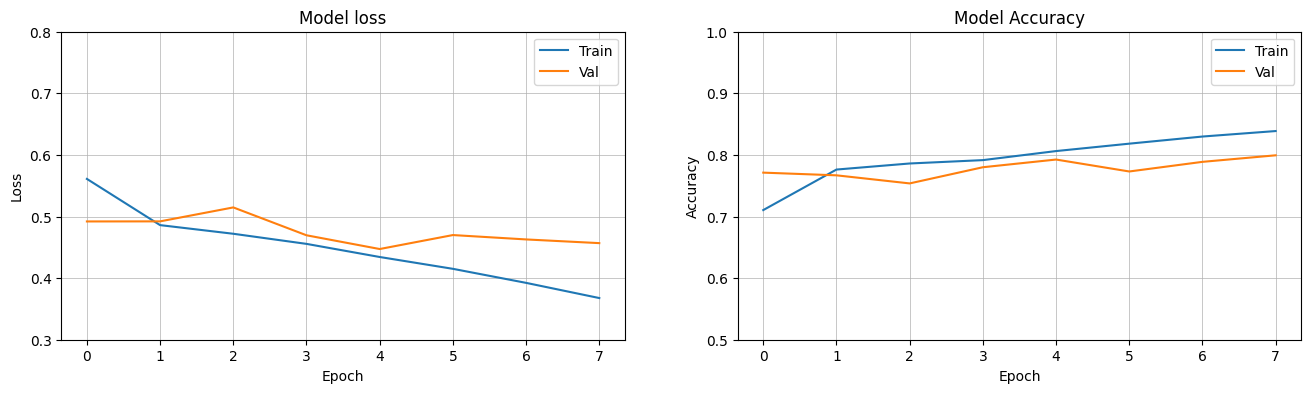

In [81]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

## Model Evaluation

In [82]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

250/250 [==============================] - 19s 74ms/step - loss: 0.4440 - accuracy: 0.8027
The accuracy on the test set is of 80.27 %
